In [ ]:
import cv2
from cv2 import aruco# Needs opencv-contrib-python==4.6.0.66
import os
import numpy as np
import matplotlib.pyplot as plt

### Old API

In [ ]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
# board = aruco.CharucoBoard_create(7, 5, 1, .8, aruco_dict)
board = aruco.CharucoBoard_create(6, 4, 1, 0.5, aruco_dict)
imboard = board.draw((2000, 2000))

In [ ]:
plt.imshow(imboard)
plt.show()

### Read images and resize them to have the same size

In [ ]:
datadir_left = "./images/left/calibration/"
datadir_front = "./images/front/calibration/"
datadir_right = "./images/right/calibration/"

image_paths_left = np.array([datadir_left + f for f in os.listdir(datadir_left) if f.endswith(".JPG") ])
image_paths_front = np.array([datadir_front + f for f in os.listdir(datadir_front) if f.endswith(".JPG") ])
image_paths_right = np.array([datadir_right + f for f in os.listdir(datadir_right) if f.endswith(".JPG") ])

image_paths_left=sorted(image_paths_left)
image_paths_front=sorted(image_paths_front)
image_paths_right=sorted(image_paths_right)

In [ ]:
len(image_paths_left), len(image_paths_front), len(image_paths_right)

In [ ]:
img_left = cv2.imread(image_paths_left[0])
print("Left image shape: ", img_left.shape)

img_front = cv2.imread(image_paths_front[0])
print("Front image shape: ", img_front.shape)

img_right = cv2.imread(image_paths_right[0])
print("Right image shape: ", img_right.shape)

In [ ]:
images_left_uncut = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in image_paths_left]
images_front_uncut = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in image_paths_front]
images_right_uncut = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in image_paths_right]

Testing detections on different crops

In [ ]:
for i, (image_l, image_f, image_r) in enumerate(zip(images_left_uncut, images_front_uncut, images_right_uncut)):
    print("Image number: ", i)
    
    # two options: like this from 500 to 1500 for the second dimension start
    image_l = image_l[1000:4150, 1300:4450, :]
    image_f = image_f[1000:4150, 1300:4450, :]
    image_r = image_r[1000:4150, 1300:4450, :]

    gray = cv2.cvtColor(image_l, cv2.COLOR_RGB2GRAY)
    markers, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
    print("Left: ", len(markers))
    
    gray = cv2.cvtColor(image_f, cv2.COLOR_RGB2GRAY)
    markers, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
    print("Front: ", len(markers))
    
    gray = cv2.cvtColor(image_r, cv2.COLOR_RGB2GRAY)
    markers, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
    print("Right: ", len(markers))
    
    plt.imshow(image_l)
    plt.show()
    plt.imshow(image_f)
    plt.show()
    plt.imshow(image_r)
    plt.show()

In [59]:
# main crop value, 1300:4450 give best result
# images_left = [img[1000:4150, 1500:4500, :].copy() for img in images_left_uncut]
# images_front = [img[1000:4150, 1500:4500, :].copy() for img in images_front_uncut]
# images_right = [img[1000:4150, 1500:4500, :].copy() for img in images_right_uncut]

images_left = [img[1000:4150, 1300:4450, :].copy() for img in images_left_uncut]
images_front = [img[1000:4150, 1300:4450, :].copy() for img in images_front_uncut]
images_right = [img[1000:4150, 1300:4450, :].copy() for img in images_right_uncut]

# images_left = [cv2.resize(img[1000:4150, 1300:4450, :], (0,0), fx=0.85, fy=0.85) for img in images_left_uncut]
# images_front = [cv2.resize(img[1000:4150, 1300:4450, :], (0,0), fx=0.85, fy=0.85) for img in images_front_uncut]
# images_right = [cv2.resize(img[1000:4150, 1300:4450, :], (0,0), fx=0.85, fy=0.85) for img in images_right_uncut]


assert images_left[0].shape==images_front[0].shape==images_right[0].shape
imsize = images_right[0].shape[0:2]

In [ ]:
imsize

this works better

In [60]:
images_left = images_left[1:2]
images_front = images_front[1:2]
images_right = images_right[1:2]

### Markers + corners

In [ ]:
def read_chessboards(images, addEmpty=False):
    """
    Finding corners on a chessboard
    """
    chessCorners = []
    chessCornersIds = []
    
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    for i, image in enumerate(images):
        print("=> Processing image {0}".format(i))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        markers, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
        print("Number of markers detected: ", len(markers))

        if len(markers)>0:
            # SUB PIXEL DETECTION
            for marker in markers:
                # check whether this one is called correctly
                cv2.cornerSubPix(gray, marker,
                                 winSize = (3,3),
                                 zeroZone = (-1,-1),
                                 criteria = criteria)
                
            res2 = cv2.aruco.interpolateCornersCharuco(markers, ids, gray, board)
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3:
                chessCorners.append(res2[1])
                chessCornersIds.append(res2[2])
            elif addEmpty:
                chessCorners.append(np.array([]))
                chessCornersIds.append(np.array([]))
        elif addEmpty:
            chessCorners.append(np.array([]))
            chessCornersIds.append(np.array([]))
#         print(len(chessCorners))

    return chessCorners, chessCornersIds

In [ ]:
print("LEFT IMAGES")
allCorners_left, allIds_left = read_chessboards(images_left)
print("FRONT IMAGES")
allCorners_front, allIds_front = read_chessboards(images_front)
print("RIGHT IMAGES")
allCorners_right, allIds_right = read_chessboards(images_right)

### Camera calibration

In [ ]:
def calibrate_camera(allCorners, allIds):
    """
    Calibrates the camera using the dected corners.
    """
# 4872, 5568
    cameraMatrixInit = np.array([[ 3150.,    0., imsize[0]/2.],
                                 [    0., 3150., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
#     flags = (cv2.CALIB_RATIONAL_MODEL)
    
#     (ret, camera_matrix, distortion_coefficients0,
#      rotation_vectors, translation_vectors,
#      stdDeviationsIntrinsics, stdDeviationsExtrinsics,
#      perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
#                       charucoCorners=allCorners,
#                       charucoIds=allIds,
#                       board=board,
#                       imageSize=imsize,
#                       cameraMatrix=cameraMatrixInit,
#                       distCoeffs=distCoeffsInit,
#                       flags=flags,
#                       criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))
    
    ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors = aruco.calibrateCameraCharuco(
        charucoCorners=allCorners,
        charucoIds=allIds,
        board=board,
        imageSize=imsize,
        cameraMatrix=cameraMatrixInit,
        distCoeffs=None,
        flags=flags,
        criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9)
    )

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [ ]:
calibration_parameters = {}

# results are ret, mtx, dist, rvecs, tvecs
res_left = calibrate_camera(allCorners_left, allIds_left)
print("Left camera calibration accuracy: ", res_left[0])
calibration_parameters['left'] = res_left

res_front = calibrate_camera(allCorners_front, allIds_front)
print("Front camera calibration accuracy: ", res_front[0])
calibration_parameters['front'] = res_front

res_right = calibrate_camera(allCorners_right, allIds_right)
print("Right camera calibration accuracy: ", res_right[0])
calibration_parameters['right'] = res_right

In [ ]:
for img, corners, ids in zip(images_right, allCorners_right, allIds_right):
    for corner, c_id in zip(corners, ids):
        print(corner, c_id)
        c = img.copy()
        
        c = cv2.circle(c, (int(corner[0][0]), int(corner[0][1])), 10, (255, 0, 0), 5)
    
        plt.imshow(c)
        plt.show()

In [ ]:
print("LEFT IMAGES")
allCorners_left, allIds_left = read_chessboards(images_left, addEmpty=True)
print("FRONT IMAGES")
allCorners_front, allIds_front = read_chessboards(images_front, addEmpty=True)
print("RIGHT IMAGES")
allCorners_right, allIds_right = read_chessboards(images_right, addEmpty=True)

In [ ]:
len(allCorners_left), len(allCorners_front), len(allCorners_right)

In [ ]:
for l, f, r in zip(allCorners_left, allCorners_front, allCorners_right):
    
#     print(
#         l.shape if len(l) != 0 else (0, 0, 0), 
#         f.shape if len(f) != 0 else (0, 0, 0), 
#         r.shape if len(r) != 0 else (0, 0, 0),
#     )
    
    print(l.shape, f.shape, r.shape)

In [ ]:
def get_common_corners_and_objpoints(allCorners_first, allIds_first, allCorners_second, allIds_second):
    corners1 = []
    corners2 = []
    objpoints = []
    
    i = 0
    for corners_first, ids_first, corners_second, ids_second in zip(allCorners_first, allIds_first, allCorners_second, allIds_second):
        common_ids = set(ids_first.flatten()).intersection(ids_second.flatten())
        
        if len(common_ids) == 0:
            print(f"No corners retrieved in the {i} image")
            i += 1
            continue
        
        print(f"Corners retrieved in the {i} image", common_ids)
        i += 1
        
        objp = []
        for c_id in common_ids:
            # first row then columns or vice-versa
            x = c_id % 5
            y = c_id // 5
            
            objp.append([float(x), float(y), 0.0])
        objpoints.append(np.array(objp, dtype=np.float32))
            
        mask1 = list(map(lambda x: x[0] in common_ids, ids_first))
        mask2 = list(map(lambda x: x[0] in common_ids, ids_second))
        
        corners1.append(corners_first[mask1].squeeze(1))
        corners2.append(corners_second[mask2].squeeze(1))
        
        assert(len(corners_first[mask1])==len(corners_second[mask2])==len(objp))
        
    return corners1, corners2, objpoints
    

In this test I collected all the images and selected the corners that are visible for both cameras

result for left and front: 2.211220747959163

result for right and front: 126.58889967955211

with crop from 1300:

2.248 and 20.57

In [49]:
corners1, corners2, objpoints = get_common_corners_and_objpoints(
    allCorners_front, 
    allIds_front,
    allCorners_left, 
    allIds_left, 
)

mtx1 = calibration_parameters['front'][1]
dst1 = calibration_parameters['front'][2]

mtx2 = calibration_parameters['left'][1]
dst2 = calibration_parameters['left'][2]

Corners retrieved in the 0 image {0, 1, 2, 3, 4, 5, 6, 9, 11, 14}


In [ ]:
corners1, corners2, objpoints = get_common_corners_and_objpoints(
    allCorners_front, 
    allIds_front,
    allCorners_right, 
    allIds_right, 
)

mtx1 = calibration_parameters['front'][1]
dst1 = calibration_parameters['front'][2]

mtx2 = calibration_parameters['right'][1]
dst2 = calibration_parameters['right'][2]

In [50]:
ret, mat1, dist1, mat2, dist2, r,t, e, f = cv2.stereoCalibrate(
    objpoints, 
    corners1, 
    corners2, 
    mtx1,
    dst1,
    mtx2, 
    dst2,
    imsize
)

[ret, mat1, dist1, mat2, dist2, r,t, e, f]

[0.45837651879543817,
 array([[2.91167579e+03, 0.00000000e+00, 1.64979047e+03],
        [0.00000000e+00, 2.91167579e+03, 1.55604693e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-2.81555695e-01, -4.27912446e+00, -1.14097463e-01,
         -3.12666224e-02,  9.58595829e+01]]),
 array([[3.06502691e+03, 0.00000000e+00, 1.56726013e+03],
        [0.00000000e+00, 3.06502691e+03, 1.56798653e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-0.36173302, -1.56581615, -0.19303805,  0.03695501, -6.25797845]]),
 array([[ 0.84029728, -0.04114902, -0.54056197],
        [ 0.04444968,  0.99898746, -0.00694907],
        [ 0.54030058, -0.01818852,  0.8412755 ]]),
 array([[26.14884974],
        [-0.92225154],
        [10.09396186]]),
 array([[ -0.94696643, -10.06696689,  -0.70572393],
        [ -5.64630992,   0.06025226, -27.45479854],
        [  1.93727351,  26.08442312,  -0.6802444 ]]),
 array([[ 1.78115773e-08,  1.89350491e-07, -2.85373963e-04],
    

In [ ]:
#projection matrix for front camera is identity
projection_front = mtx1 @ np.concatenate([np.eye(3), [[0],[0],[0]]], axis = -1) 
 
#projection matrix for left camera is the R and T obtained from stereo calibration
projection_left = mtx2 @ np.concatenate([r, t], axis = -1) 

In [ ]:
projection_front

### Testing fundamental matrix properties

In [52]:
def drawlines(img1, img2, lines, pts1, pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c, _ = img1.shape

    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = (0, 255, 255)
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 10)
        img1 = cv2.circle(img1, (int(pt1[0]), int(pt1[1])), 25, color, -1)
        img2 = cv2.circle(img2, (int(pt2[0]), int(pt2[1])), 25, color, -1)
    return img1, img2

In [ ]:
corner_index = 5

In [ ]:
line_2 = cv2.computeCorrespondEpilines(np.array([[2000, 2500]]), 1, f)
# line_2 = cv2.computeCorrespondEpilines(allCorners_front[0][corner_index], 1, f)

In [ ]:
line = f @ [2000, 2500, 1]

In [ ]:
line

In [ ]:
line_2 = line_2.squeeze(0).squeeze(0)
line_2

In [ ]:
img1, img2 = drawlines(
                     images_left[1].copy(), 
                     images_front[1].copy(),
                     [line, line_2], 
#                      allCorners_left[0][corner_index], 
#                      allCorners_front[0][corner_index],
                    np.array([[0, 0]]),
                    np.array([[2000, 2500]])
    )
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

# Kevin's code

## 3D Reconstruction from calibrated cameras
First, we need to create a SIFT

In [28]:
sift = cv2.SIFT_create()
keypoints = {}

kp, des = sift.detectAndCompute(images_left[0], None)
keypoints['left'] = {'KeyPoint':kp, 'Descriptor':des}

kp, des = sift.detectAndCompute(images_front[0], None)
keypoints['front'] = {'KeyPoint':kp, 'Descriptor':des}

#     plt.figure(figsize=(16, 12), dpi=80)
# plt.imshow(cv2.drawKeypoints(img,kp,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
# plt.show()

### Brute force based matching method

We will start with brute force type method, as it seems to work in any cases.

Try to test Flann based method later to see if it is better/worse

In [29]:
brute_force_match = cv2.BFMatcher()

match = brute_force_match.knnMatch(keypoints['front']['Descriptor'], keypoints['left']['Descriptor'], k=2)

### Lowes ratio
[this is a good explanation of Lowes ratio](https://stackoverflow.com/questions/51197091/how-does-the-lowes-ratio-test-work)

In [42]:
len(keypoints['left']['KeyPoint']), len(keypoints['front']['KeyPoint']), len(match)

(7342, 4379, 4379)

In [44]:
pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i, (m, n) in enumerate(match):
    if m.distance < 0.8 * n.distance:
        pts2.append(keypoints['left']['KeyPoint'][m.trainIdx].pt)
        pts1.append(keypoints['front']['KeyPoint'][m.queryIdx].pt)
        
pts1 = np.float32(pts1)
pts2 = np.float32(pts2)

### Triangulation to get points in space

In [45]:
triangulated_points = cv2.triangulatePoints(projection_front, projection_left, pts1.T, pts2.T)
triangulated_points.shape

(4, 280)

In [ ]:
triangulated_points[2]= -triangulated_points[2]
plt.scatter(triangulated_points[:,0],triangulated_points[:,1],triangulated_points[:,2])

### Epipolar lines using calibration board

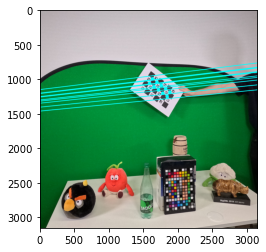

In [70]:
# lines = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, f)
lines = cv2.computeCorrespondEpilines(allCorners_left[0], 2, f)
lines = lines.reshape(-1, 3)

img1, img2 = drawlines(
    images_front[0].copy(), 
    images_left[0].copy(), 
    lines, 
    allCorners_front[0].reshape(-1,2), 
    allCorners_left[0].reshape(-1,2)
)

plt.imshow(img1)
plt.show()

# plt.imshow(img2)
# plt.show()

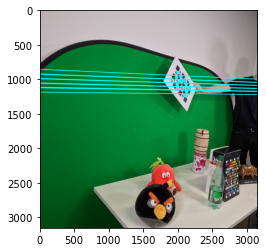

In [69]:
lines = cv2.computeCorrespondEpilines(allCorners_front[0], 1, f)
lines = lines.reshape(-1, 3)

img1, img2 = drawlines(
    images_left[0].copy(), 
    images_front[0].copy(), 
    lines, 
    allCorners_left[0].reshape(-1,2),
    allCorners_front[0].reshape(-1,2), 
)

plt.imshow(img1)
plt.show()

# plt.imshow(img2)
# plt.show()